In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from scipy import stats
import math
from sklearn.preprocessing import StandardScaler, RobustScaler
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df_train = pd.read_csv("train.csv", encoding="utf-8")
df_test = pd.read_csv("test.csv", encoding = "utf-8")

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## 1. Feature analysis
- In the kaggle page, author selected Saleprice as a dependent variable, which we have to predict.
- Further, he selects GrLivArea, TotalBsmtSF, OverallQual, YearBuilt as a important dependent variables for analyzing Saleprice.
- So firstly find the relationship with 4 important variables and dependent variable

In [4]:
df_train.SalePrice.describe().astype(int)

count      1460
mean     180921
std       79442
min       34900
25%      129975
50%      163000
75%      214000
max      755000
Name: SalePrice, dtype: int32

In [5]:
print(f"Skewness: {df_train.SalePrice.skew():.4f}")
print(f"Kurtosis: {df_train.SalePrice.kurt():.4f}")

Skewness: 1.8829
Kurtosis: 6.5363


### 1.1 Analyze main featrues with the graph(Visualization practive)
- Use Gridspec for organize multiple subplots in one plot

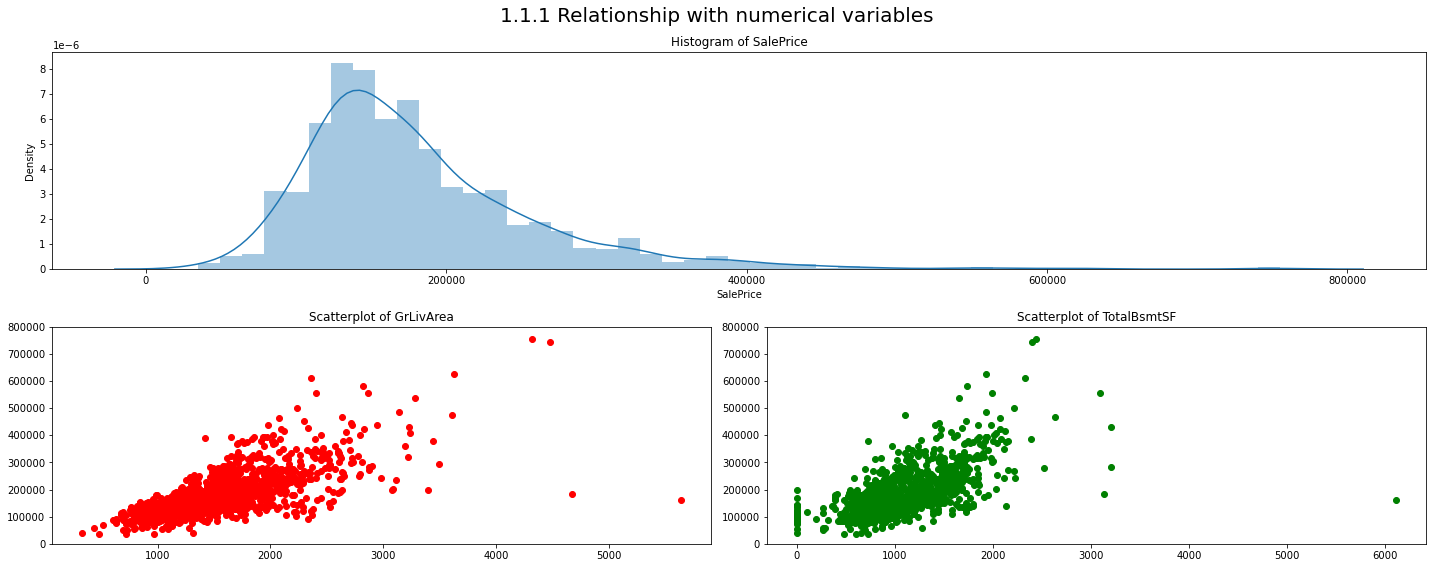

In [6]:
fig = plt.figure(constrained_layout = True, figsize = (20, 8))
grid = plt.GridSpec(2, 2)

#ax = axis.flatten()
ax1 = fig.add_subplot(grid[0, 0:])
sns.distplot(df_train.SalePrice)
ax1.set(title = "Histogram of SalePrice")

ax2 = fig.add_subplot(grid[1, 0])
plt.scatter(x = df_train.GrLivArea, y = df_train.SalePrice, color = "red")
ax2.set(ylim = (0, 800000), title = "Scatterplot of GrLivArea")

ax3 = fig.add_subplot(grid[1, 1])
plt.scatter(x = df_train.TotalBsmtSF, y = df_train.SalePrice, color = "green")
ax3.set(ylim = (0, 800000), title = "Scatterplot of TotalBsmtSF")

plt.suptitle("1.1.1 Relationship with numerical variables", fontsize = 20)
plt.tight_layout()
plt.show()

- Can find positive linear relationship between SalePrice and GrilvArea, TotalBsmtSF

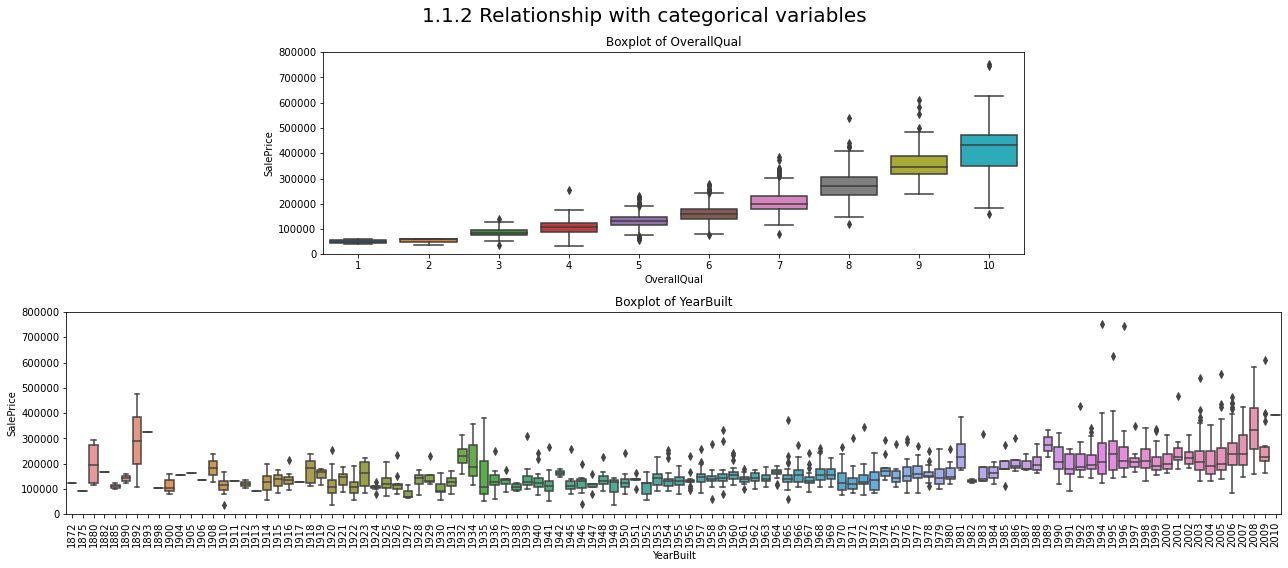

In [7]:
fig = plt.figure(figsize = (18, 8))
grid = plt.GridSpec(2, 5)

ax1 = fig.add_subplot(grid[0, 1:4])
sns.boxplot(x = df_train.OverallQual, y = df_train.SalePrice);
ax1.set(title = "Boxplot of OverallQual", ylim = (0,800000))

ax2 = fig.add_subplot(grid[1, 0:])
sns.boxplot(x = df_train.YearBuilt, y = df_train.SalePrice);
ax2.set(title = "Boxplot of YearBuilt", ylim = (0,800000))
ax2.tick_params(axis = 'x', labelrotation = 90)

plt.suptitle("1.1.2 Relationship with categorical variables", fontsize = 20)
plt.tight_layout()
plt.show()

- Can find positive relationship between SalePrice and OverallQual, 
- Positive relatinship between SalePrice and YearBuilt is not strong, but still Saleprice tend to be higher for the new built house

### In summary(from author)
Stories aside, we can conclude that:

- 'GrLivArea' and 'TotalBsmtSF' seem to be linearly related with 'SalePrice'. Both relationships are positive, which means that as one variable increases, the other also increases. In the case of 'TotalBsmtSF', we can see that the slope of the linear relationship is particularly high.

- 'OverallQual' and 'YearBuilt' also seem to be related with 'SalePrice'. The relationship seems to be stronger in the case of 'OverallQual', where the box plot shows how sales prices increase with the overall quality.

## 2. Other variables

- 4 variables below are selected by the intuition
- Hence, need some more objective starting points for selecting important variables
- To explore the whole variables,
1. Correlation matrix
2. SalesPrice Correlation matrix
3. Scatter plots between the most correlated varaibles

Could help this problem

### 2.1 Correlation matrix

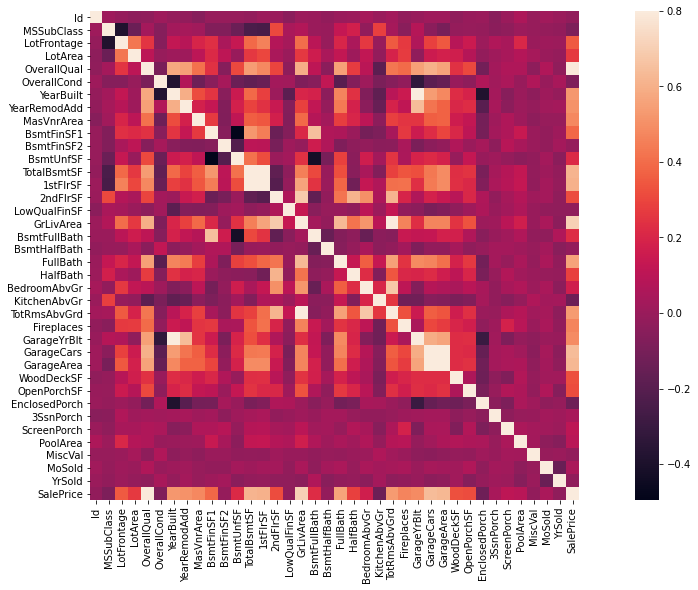

In [8]:
corrmat = df_train.corr()
fig = plt.figure(figsize = (20, 9));
sns.heatmap(corrmat, vmax = .8, square = True, 
            annot = False,  fmt = '.2f', annot_kws = {"size": 7});

It's not easy to define the most correlated vriables with this heatmap.

Let's find the top 10 correlated variables.

### 2.2 Find top 10 Correlation matrix with SalePrice

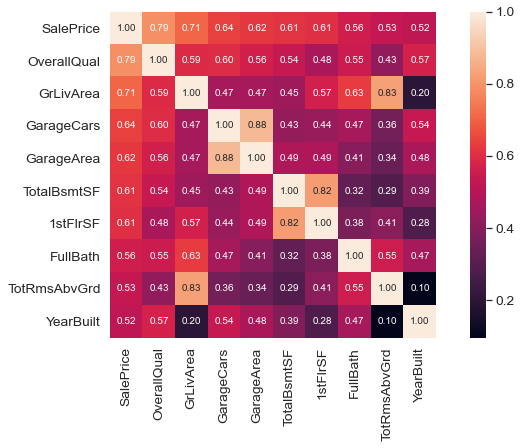

In [9]:
k = 10 # Top 10 high correlated variables
cols = corrmat.nlargest(k, "SalePrice").index
cm = np.corrcoef(df_train[cols].values.T)

fig = plt.figure(figsize = (12, 6));
sns.set(font_scale = 1.25)
hm = sns.heatmap(cm, cbar = True, annot = True, square = True, 
                 fmt = '.2f', annot_kws = {"size": 10}, 
                 yticklabels = cols.values, xticklabels = cols.values)
plt.show()

1. Variables I used before "OverallQual" and "GrLivaArea" are the most higly related to the Saleprice
2. GarageCars and GarageArea are aslo have a high relationship, but two of variable seem to have high relationship(0.88) which means number of cars in Garage is the consequence of Garagearea. Therefore I can keep just GarageArea, which have higher relationship
3. TotalBsmtSF and 1stFloor also seem have high relationship(0.82). Just keep TotalBstmSF 
4. TotRmsAbvGrd is similar to GrLivaArea
5. Actually Yearbuilt that author tought it would higly correlated to the Saleprice is not that related.
6. Below is the new variables column and will keep that columns for compare to the accuracy of linear regression



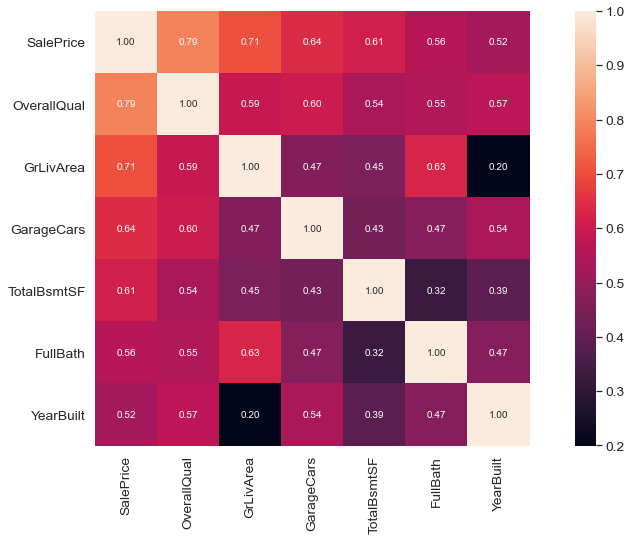

In [10]:
col_sub = ["1stFlrSF", "GarageArea", "TotRmsAbvGrd"]
new_cols = [x for x in cols if x not in col_sub]
new_df_train = df_train[new_cols]

cm = np.corrcoef(df_train[new_cols].values.T)

fig = plt.figure(figsize = (16, 8));
sns.set(font_scale = 1.25)
hm = sns.heatmap(cm, cbar = True, annot = True, square = True, 
                 fmt = '.2f', annot_kws = {"size": 10}, 
                 yticklabels = new_cols, xticklabels = new_cols)
plt.show()

## 2.2 Scatterplot with SalePrice
Now let's see the scatterplot of top 6 variables and Saleprice

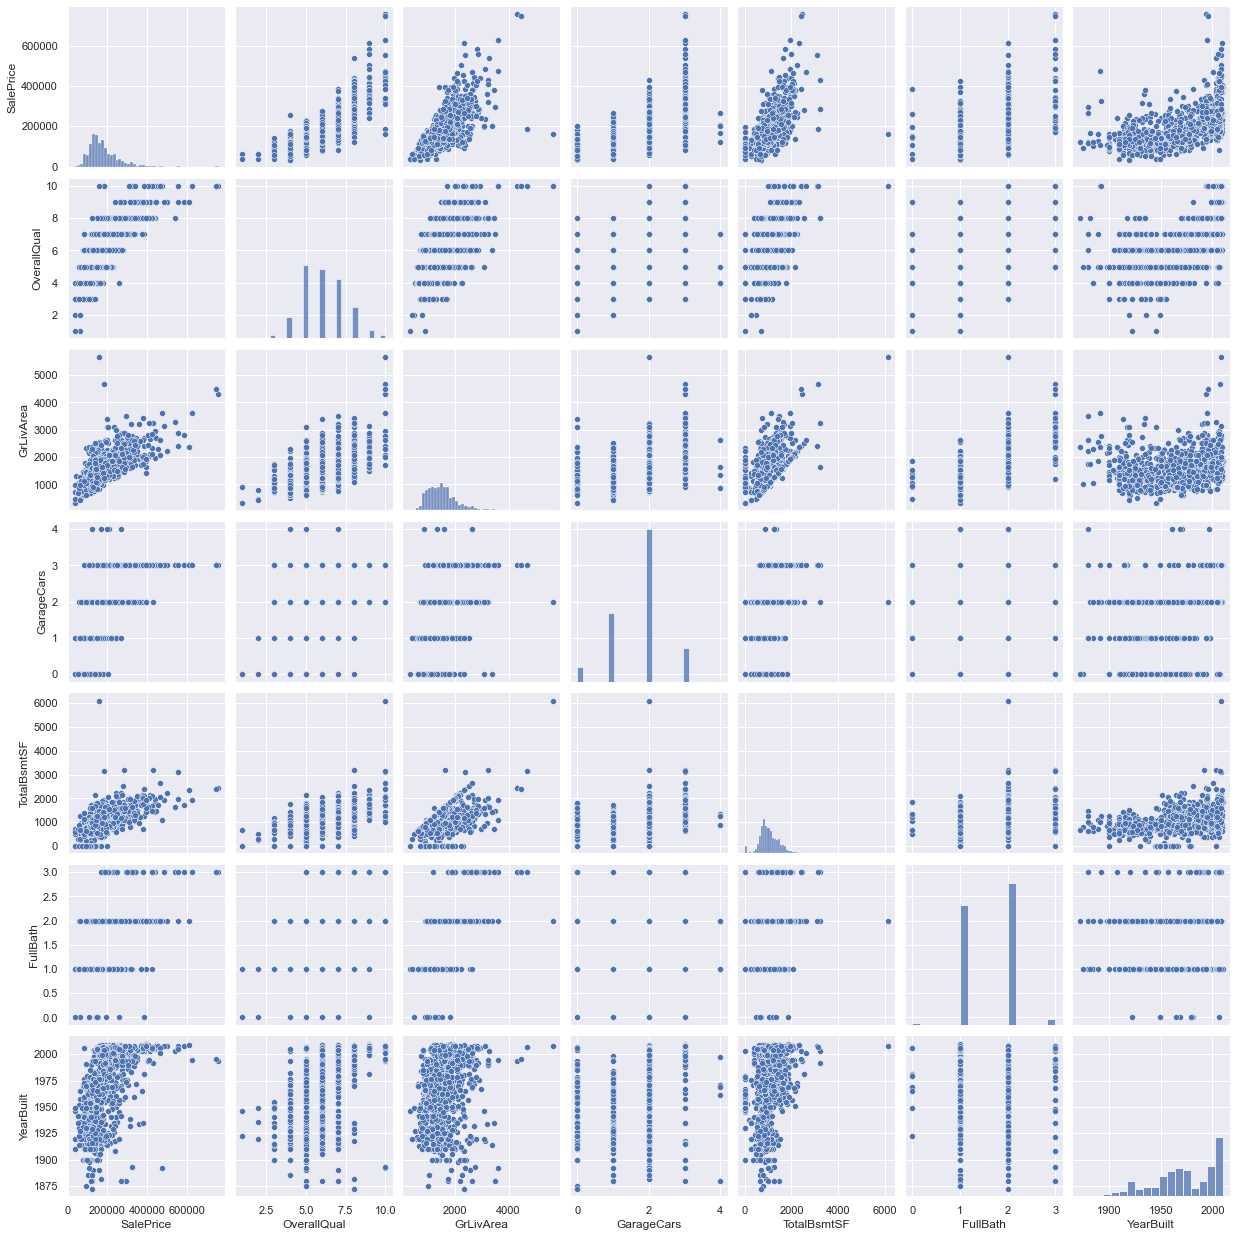

In [11]:
col_sub = ["1stFlrSF", "GarageArea", "TotRmsAbvGrd"]
sns.set()
new_cols = [x for x in cols if x not in col_sub]
sns.pairplot(df_train[new_cols], size = 2.5)
plt.show()

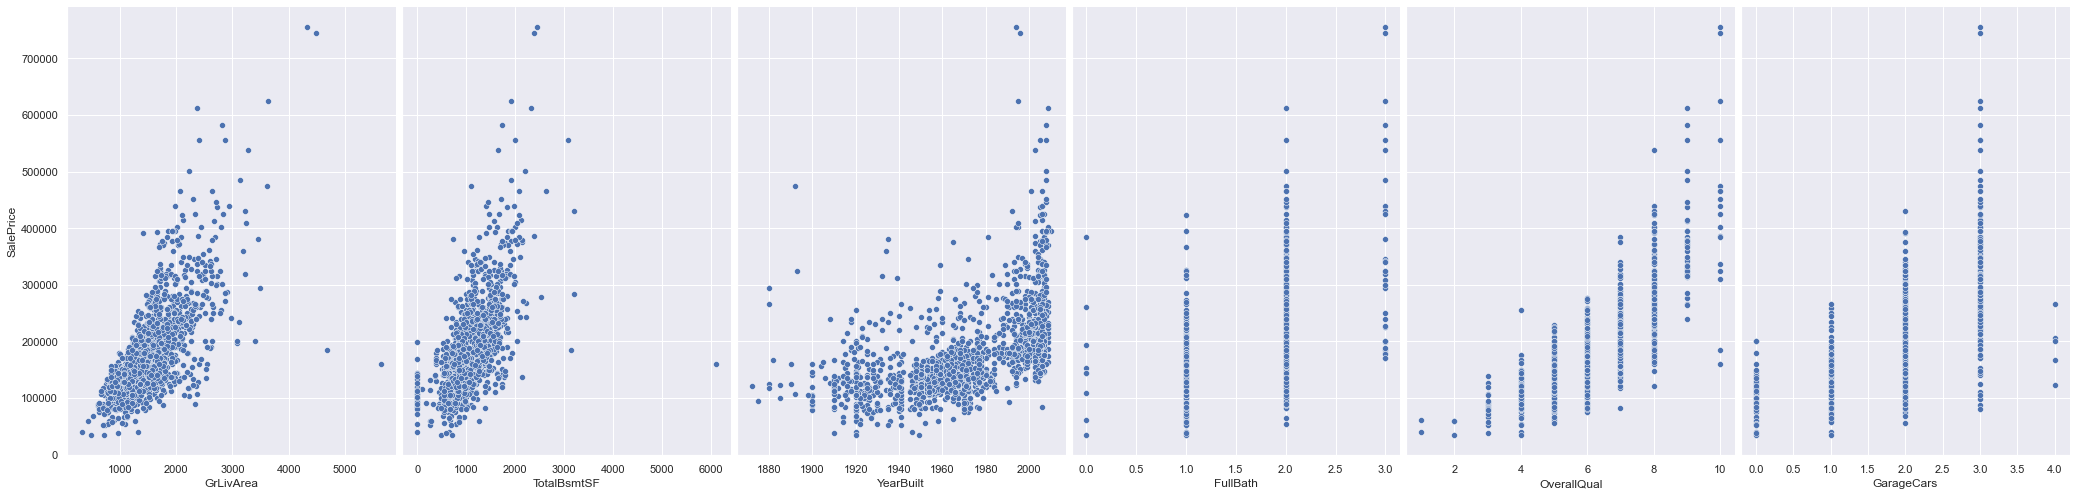

In [12]:
sns.pairplot(new_df_train, x_vars = ['GrLivArea', 'TotalBsmtSF', 'YearBuilt', 'FullBath', 'OverallQual',  'GarageCars'], y_vars="SalePrice", size = 7 , aspect = 0.7);

### Explanation from Author

Although we already know some of the main figures, this mega scatter plot gives us a reasonable idea about variables relationships.

- One of the figures we may find interesting is the one between 'TotalBsmtSF' and 'GrLiveArea'. 
    - In this figure we can see the dots drawing a linear line, which almost acts like a border. 
    - It totally makes sense that the majority of the dots stay below that line. 
    - Basement areas can be equal to the above ground living area, but it is not expected a basement area bigger than the above ground living area (unless you're trying to buy a bunker).

- The plot concerning 'SalePrice' and 'YearBuilt' can also make us think. 
    - In the bottom of the 'dots cloud', we see what almost appears to be a shy exponential function (be creative). 
    - We can also see this same tendency in the upper limit of the 'dots cloud' (be even more creative). 
    - Also, notice how the set of dots regarding the last years tend to stay above this limit (I just wanted to say that prices are increasing faster now).

## 3. Missing data

Important questions when thinking about missing data:

- How prevalent is the missing data?
- Is missing data random or does it have a pattern?

The answer to these questions is important for practical reasons because missing data can imply a reduction of the sample size. This can prevent us from proceeding with the analysis. Moreover, from a substantive perspective, we need to ensure that the missing data process is not biased and hidding an inconvenient truth.

In [13]:
import missingno as msno # Missingvalue visualization tool

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

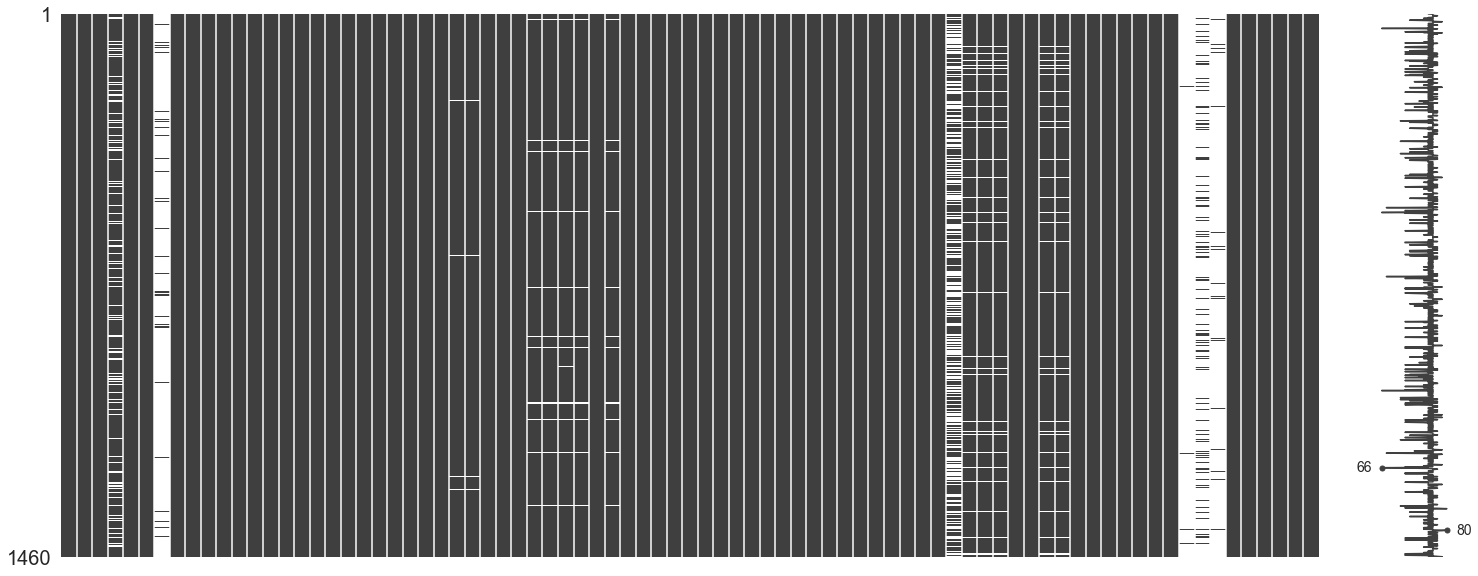

In [14]:
# See the overall missingvalue
df_train.info()
msno.matrix(df_train);

In [15]:
# Look more detail with the datarframe and percentage
total = df_train.isnull().sum().sort_values(ascending = False)
percentage = round((df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending = False)*100,2)
missing_data = pd.DataFrame({"missing_values" : total, "percentage": percentage})
missing_data.head(20)

,missing_values,percentage
PoolQC,1453,99.52
MiscFeature,1406,96.30
Alley,1369,93.77
Fence,1179,80.75
FireplaceQu,690,47.26
LotFrontage,259,17.74
GarageYrBlt,81,5.55
GarageCond,81,5.55
GarageType,81,5.55
GarageFinish,81,5.55


1. Basically variables which contain more than 15% of missivalue should be deleted since it is not usable anymore.
- Even when we use some statistic method, fill it with the mean, max, min it will disturb to make the accurate analysis
- Also those kind of varaibles seem to be not considerable varaible when we buy the house
- Add, it is easy to find the outliar in those kind of varaibles
- Will deelte from PoolQc to LotFrontage

2. Garage~~ , Bsmt~~ , have the same amounts of missingvalues.
- It probably because they are the same category
- Also Garage~~ values may can substitue by the GarageCars variable
- Same for Bsmt~~ variable

3. Fruther, MasVnrArea, MasVrnType seems not to be the essential variables, and they have a strong correlation with YearBuilt and OverallQual, we can delete it

4. Finally I will delete all the variables contain missingvalue without Electrical. Then just delete the data with missingvalue of Electrical variable(1 data).

Number of Nan Values: 0


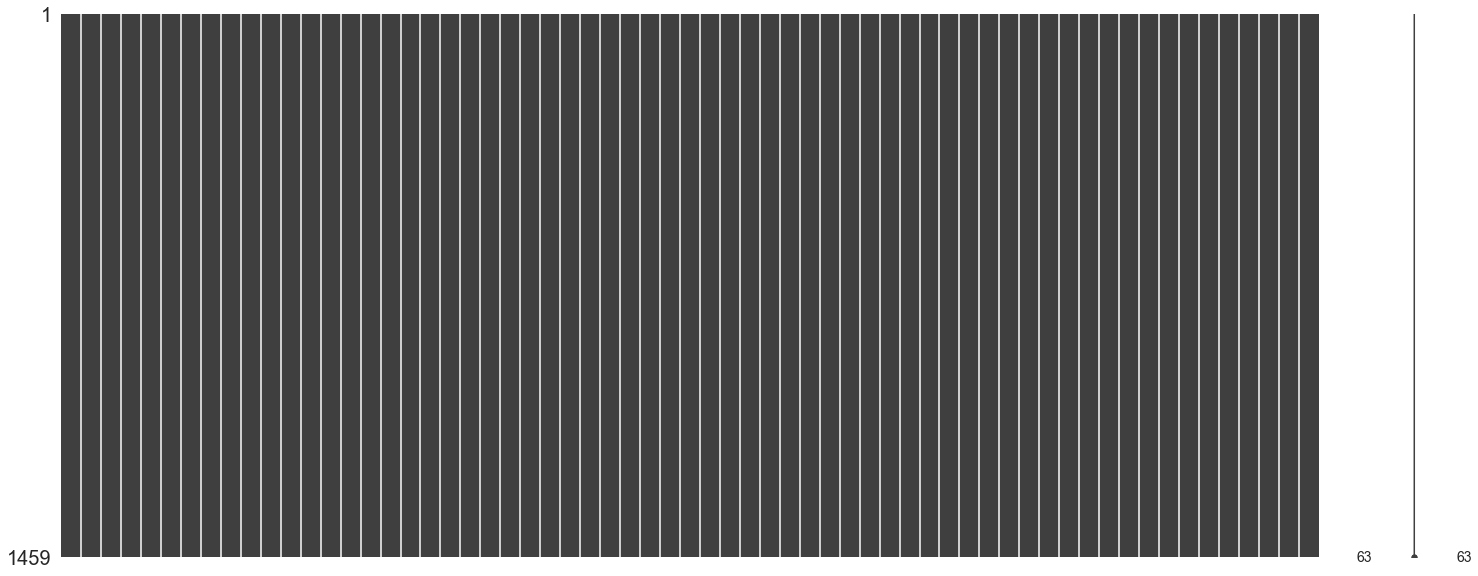

In [16]:
# Delete the mssing data
df_train.drop(missing_data[missing_data["missing_values"] > 1].index, axis = 1, inplace = True)
df_train.dropna(subset = ["Electrical"], inplace = True)
print("Number of Nan Values:", df_train.isnull().sum().max())
msno.matrix(df_train);

## 4. Outliars

- Outliers can markedly affect our models and can be a valuable source of information, providing us insights about specific behaviours.
- Outliers is a complex subject and it deserves more attention. Here, we'll just do a quick analysis through the standard deviation of 'SalePrice' and a set of scatter plots.

### 4.1 Univariate analysis
- The primary concern here is to establish a threshold that defines an observation as an outlier. 
- To do so, we'll standardize the data. In this context, data standardization means converting data values to have mean of 0 and a standard deviation of 1.

In [17]:
standardscaler = StandardScaler()
robustScaler = RobustScaler()
scaled_saleprice = standardscaler.fit_transform(df_train[["SalePrice"]])
low_range = [list(x) for x in sorted(scaled_saleprice)[:10]]
high_range = [list(x) for x in sorted(scaled_saleprice)[-10:]]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.8382077457449522], [-1.8330341420949536], [-1.8004442154529932], [-1.7828212346500791], [-1.774009744248622], [-1.6229556230807864], [-1.61666170136546], [-1.5851920927888277], [-1.5851920927888277], [-1.5726923642621893]]

outer range (high) of the distribution:
[[3.827580582391945], [4.039522102233849], [4.494736284216552], [4.7087296225376525], [4.728631003001515], [5.060345853086082], [5.421919067788157], [5.589878662683359], [7.100419874361714], [7.226298308668244]]


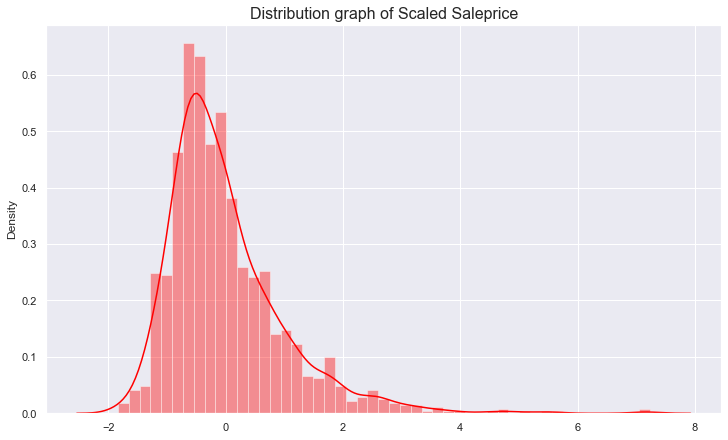

In [18]:
fig = plt.figure(constrained_layout = True, figsize = (10, 6))
sns.distplot(pd.DataFrame(standardscaler.fit_transform(df_train[["SalePrice"]]), columns = ["standard_scaled_saleprice"]), color = "red")

plt.title("Distribution graph of Scaled Saleprice", fontsize = 16)
plt.show()

How 'SalePrice' looks with her new clothes:

- Low range values are similar and not too far from 0.
- High range values are far from 0 and the 7.something values are really out of range.

For now, we'll not consider any of these values as an outlier but we should be careful with those two 7.something values.

### 4.2 Bivariate analysis

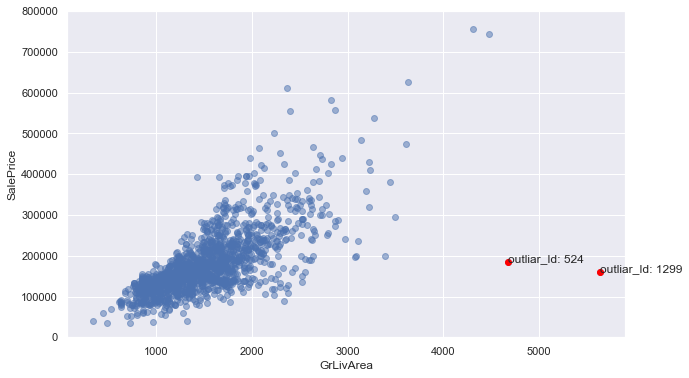

In [19]:
# bivariate analysis for saleprice - grlivarea

grlivarea_data = df_train[["SalePrice", "GrLivArea", "Id"]]
is_outlier = grlivarea_data.sort_values(by = "GrLivArea", ascending = False)[:2]


fig = plt.figure(figsize = (10, 6))

plt.ylim(0, 800000)
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")

plt.scatter(x = grlivarea_data["GrLivArea"], y = grlivarea_data["SalePrice"], alpha = 0.5)
plt.scatter(x = is_outlier['GrLivArea'], y = is_outlier['SalePrice'], color = "red")
# plt.ylim(0, 800000)
for i in range(is_outlier.shape[0]):
    plt.annotate(f"outliar_Id: {str(is_outlier.Id.tolist()[i])}", xy = (is_outlier.GrLivArea.tolist()[i], is_outlier.SalePrice.tolist()[i]))

plt.show()


- For the GrLivArea, we can find 2 points which is far from the mainstream
1. We can make some assumption the reason why this points are so far from the mainstream and have the low price.
2. Maybe this is becase they refer to agricultural area and that could explain the low price.
3. It could be right or wrong but this points are not representative of the typical case.
4. We can define it as a outliar and delete them.

- For the Saleprice we also can find 2 points that have high price
1. We already obesearved the points in the outliar part.
2. We will not delete it but should be carful it.
3. Aslo this points are still in the trend of the scatter plot

In [20]:
# Delete outliar of GrLivArea
print("Lowest GrLivArea Id before delete\n", df_train.sort_values(by = "GrLivArea", ascending = False)[["Id", "GrLivArea"]][:4])
df_train= df_train.loc[~((df_train["Id"] == 1299) | ((df_train["Id"] == 524)))]
print("Lowest GrLivArea Id after delete\n", df_train.sort_values(by = "GrLivArea", ascending = False)[["Id", "GrLivArea"]][:4])

Lowest GrLivArea Id before delete
         Id  GrLivArea
1298  1299       5642
523    524       4676
1182  1183       4476
691    692       4316
Lowest GrLivArea Id after delete
         Id  GrLivArea
1182  1183       4476
691    692       4316
1169  1170       3627
185    186       3608


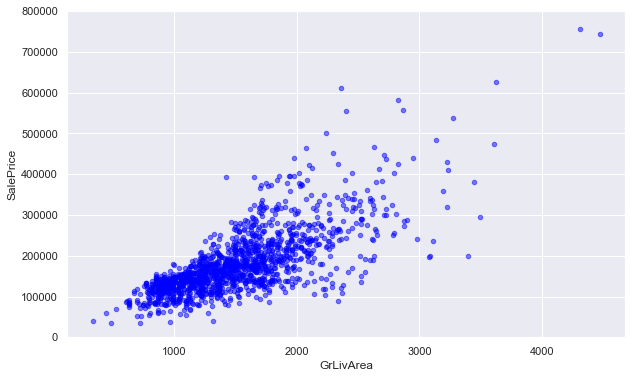

In [21]:
# Scatterplot after deleting outliar

df_train[["SalePrice", "GrLivArea"]].plot.scatter(x = "GrLivArea", y = "SalePrice", ylim = (0, 800000), figsize = (10,6), alpha = 0.5, color = "blue");

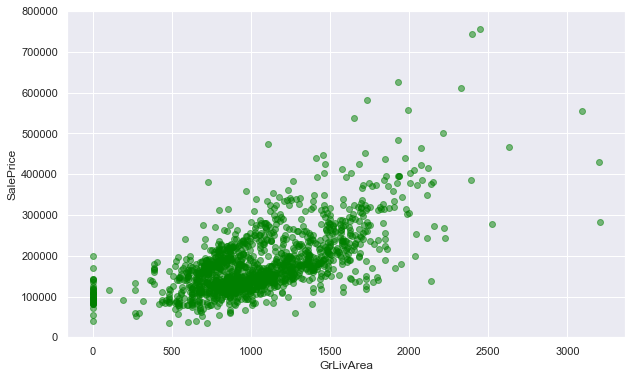

In [22]:
# bivariate analysis for saleprice - TotalBsmtSF

grlivarea_data = df_train[["SalePrice", "TotalBsmtSF", "Id"]]


fig = plt.figure(figsize = (10, 6))

plt.ylim(0, 800000)
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")

plt.scatter(x = grlivarea_data["TotalBsmtSF"], y = grlivarea_data["SalePrice"], color = "green", alpha = 0.5)

plt.show()


## 5. More about statiscal analysis(Assumption of linear regression)


* Testing for the assumptions underlying the statistical bases for multivariate analysis. 
* We already did some data cleaning and discovered a lot about 'SalePrice'. 
* Now it's time to go deep and understand how 'SalePrice' complies with the statistical assumptions that enables us to apply multivariate techniques.

1. **Normality** 
    - Normality means that the data should look like a normal distribution. 
    - This is important because several statistic tests rely on this (e.g. t-statistics). 
    - In this part I will just check univariate normality for 'SalePrice' (which is a limited approach). 
    - Remember that univariate normality doesn't ensure multivariate normality (which is what we would like to have), but it helps. 
    - Another detail to take into account is that in big samples (>200 observations) normality is not such an issue. However, if we solve normality, we avoid a lot of other problems (e.g. heteroscedacity) so that's the main reason why we are doing this analysis.
    
2. **Homoscedasticity** 
    - Homoscedasticity refers to the 'assumption that dependent variable(s) exhibit equal levels of variance across the range of predictor variable(s).
    - Homoscedasticity is desirable because we want the error term to be the same across all values of the independent variables.

3. **Linearity** 
    - The most common way to assess linearity is to examine scatter plots and search for linear patterns. 
    - If patterns are not linear, it would be worthwhile to explore data transformations. 
    - However, we'll not get into this because most of the scatter plots below have linear relationships.
    
4. **Absence of correlated errors** 
    - Correlated errors, like the definition suggests, happen when one error is correlated to another. 
    - For instance, if one positive error makes a negative error systematically, it means that there's a relationship between these variables. 
    - This occurs often in time series, where some patterns are time related. 
    - Since this is not time seires data, I'll  not get into this. 
    - Usually if something is detected related to this error, try to add a variable that can explain the effect you're getting. That's the most common solution for correlated errors

### 5.1 Normality

- The things have to pay attention to check normality are
    - **Histogram** : Kurtosis and skewness
    - **Normal probability plot** : Data distribution should closely follow the diagonal that represent the normal distribution

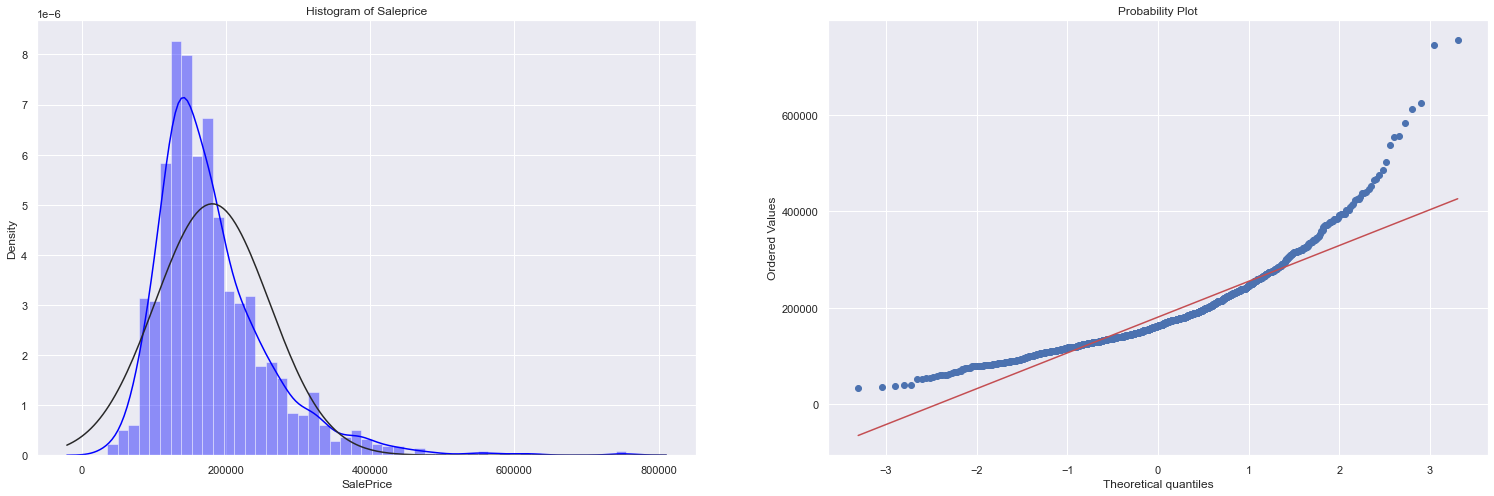

In [23]:
# Histogram and normal probability plot
fig = plt.figure(constrained_layout = True, figsize = (26, 8))
grid = plt.GridSpec(1, 2)

ax1 = fig.add_subplot(grid[0])
sns.distplot(df_train.SalePrice, color = "blue", fit = norm);
ax1.set_title("Histogram of Saleprice")
ax1.set_xlabel("SalePrice")

ax2 = fig.add_subplot(grid[1])
stats.probplot(df_train['SalePrice'], plot=plt)
plt.show()

- 'SalePrice' is not normal. It shows 'peakedness', positive skewness and does not follow the diagonal line.
- In case of positive skewness, log transformations usually works well.

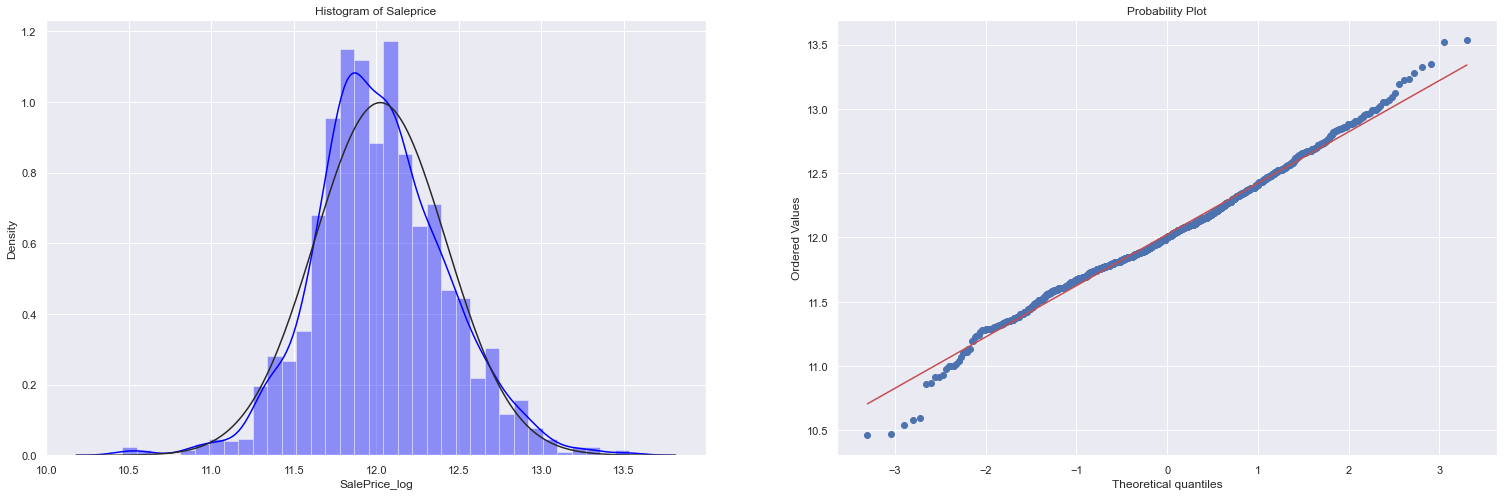

In [24]:
# Take a log for the Saleprice and make a plot
df_train["saleprice_log"] = np.log(df_train.SalePrice)
# Histogram and normal probability plot
fig = plt.figure(constrained_layout = True, figsize = (26, 8))
grid = plt.GridSpec(1, 2)

ax1 = fig.add_subplot(grid[0])
sns.distplot(df_train["saleprice_log"], color = "blue", fit = norm);
ax1.set_title("Histogram of Saleprice")
ax1.set_xlabel("SalePrice_log")

ax2 = fig.add_subplot(grid[1])
stats.probplot(df_train["saleprice_log"], plot=plt)
plt.show()

Can find the Saleprice have a normality

Next is check the normality of GrLivArea

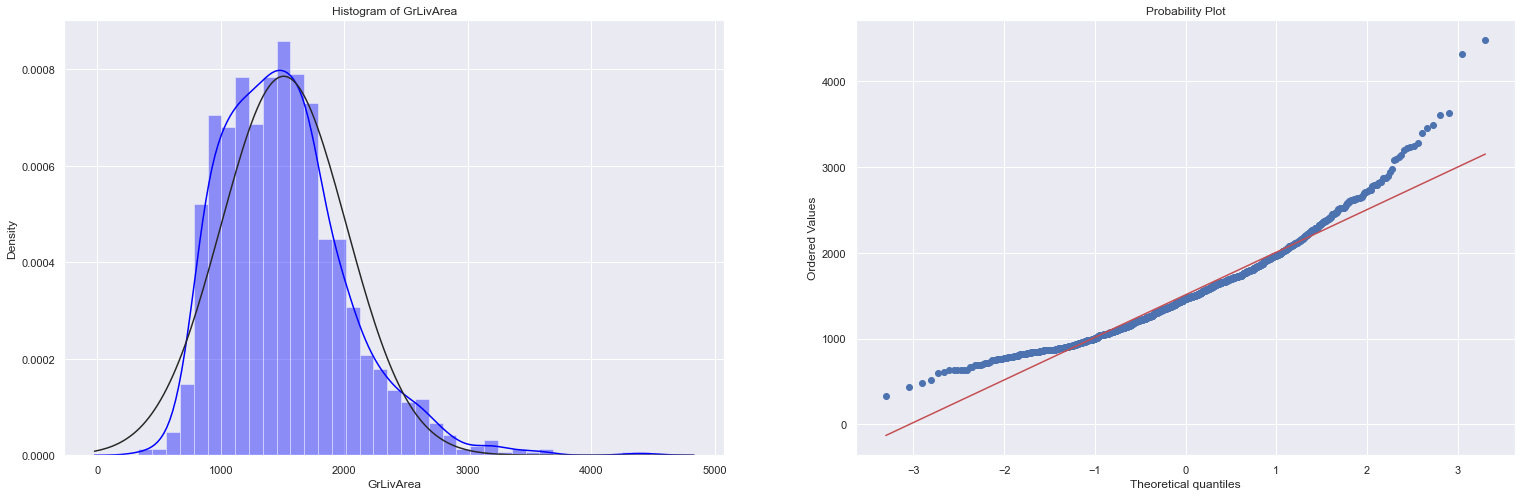

In [25]:
# Histogram and normal probability plot
fig = plt.figure(constrained_layout = True, figsize = (26, 8))
grid = plt.GridSpec(1, 2)

ax1 = fig.add_subplot(grid[0])
sns.distplot(df_train.GrLivArea, color = "blue", fit = norm);
ax1.set_title("Histogram of GrLivArea")
ax1.set_xlabel("GrLivArea")

ax2 = fig.add_subplot(grid[1])
stats.probplot(df_train['GrLivArea'], plot=plt)
plt.show()

This variable also right skewed.

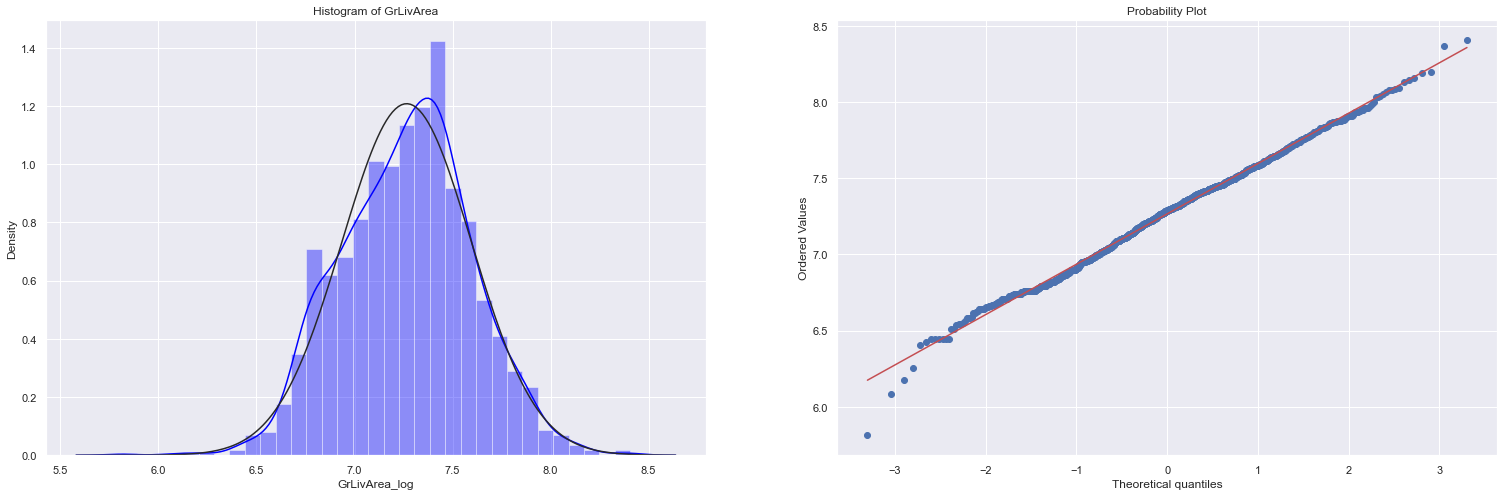

In [26]:
# Take a log for the Saleprice and make a plot
df_train["GrLivArea_log"] = np.log(df_train.GrLivArea)
# Histogram and normal probability plot
fig = plt.figure(constrained_layout = True, figsize = (26, 8))
grid = plt.GridSpec(1, 2)

ax1 = fig.add_subplot(grid[0])
sns.distplot(df_train["GrLivArea_log"], color = "blue", fit = norm);
ax1.set_title("Histogram of GrLivArea")
ax1.set_xlabel("GrLivArea_log")

ax2 = fig.add_subplot(grid[1])
stats.probplot(df_train["GrLivArea_log"], plot=plt)
plt.show()

Next is for TotalBsmtSF

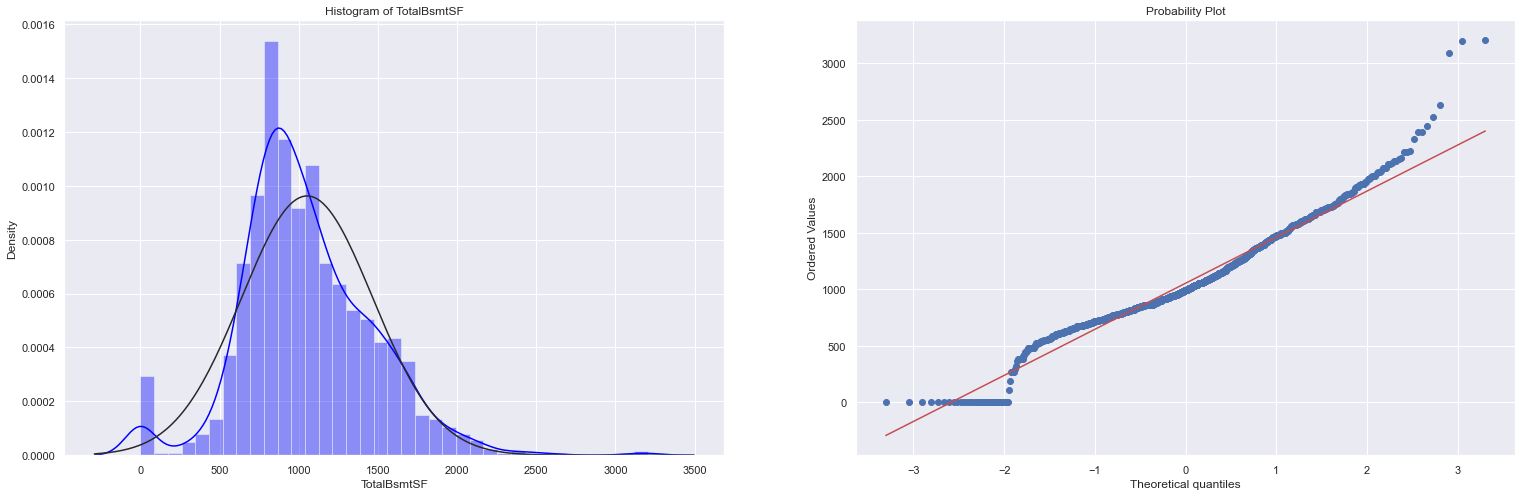

In [27]:
# Histogram and normal probability plot
fig = plt.figure(constrained_layout = True, figsize = (26, 8))
grid = plt.GridSpec(1, 2)

ax1 = fig.add_subplot(grid[0])
sns.distplot(df_train.TotalBsmtSF, color = "blue", fit = norm);
ax1.set_title("Histogram of TotalBsmtSF")
ax1.set_xlabel("TotalBsmtSF")

ax2 = fig.add_subplot(grid[1])
stats.probplot(df_train['TotalBsmtSF'], plot=plt)
plt.show()

Data of TotalBsmtSF has the problem.

- Something that, in general, presents skewness.
- A significant number of observations with value zero (houses without basement).
- A big problem because the value zero doesn't allow us to do log transformations.
- Take a log to value over 0


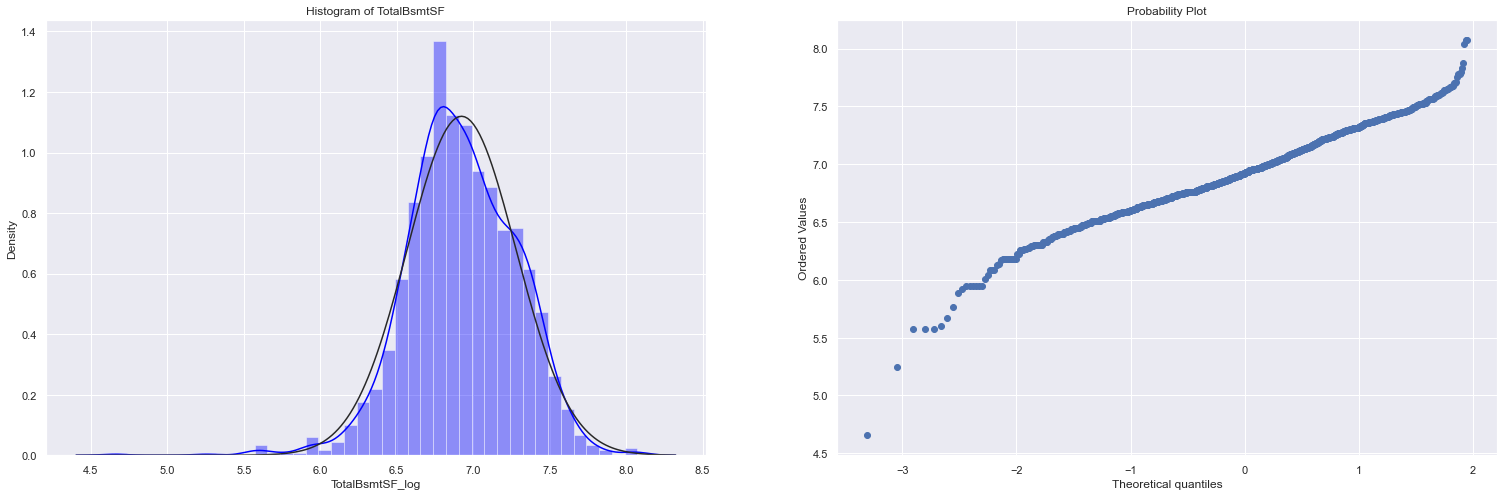

In [28]:
# Select value over 0 and take a log
df_train["TotalBsmtSF_log"] = np.log(df_train["TotalBsmtSF"].loc[df_train["TotalBsmtSF"] > 0])

# Histogram and normal probability plot
fig = plt.figure(constrained_layout = True, figsize = (26, 8))
grid = plt.GridSpec(1, 2)

ax1 = fig.add_subplot(grid[0])
sns.distplot(df_train["TotalBsmtSF_log"], color = "blue", fit = norm);
ax1.set_title("Histogram of TotalBsmtSF")
ax1.set_xlabel("TotalBsmtSF_log")

ax2 = fig.add_subplot(grid[1])
stats.probplot(df_train["TotalBsmtSF_log"], plot=plt)
plt.show()

In [29]:
df_train["TotalBsmtSF_log"].fillna(0, inplace = True)

- Wiht this session, I can find that taking log for the skewness varaible help a lot to solve the problem.
- This will be helpful to make more accurate prediction for the Houseprice when I use machinelearning or regression.

### 5.2 Homoscedasticity
Again and more detail, 
- The assumption of homoscedasticity (meaning “same variance”) is central to linear regression models.  
- Homoscedasticity describes a situation in which the error term (that is, the “noise” or random disturbance in the relationship between the independent variables and the dependent variable) is the same across all values of the independent variables.  
- If this assumption is violated, then the standard errors will be biased.
- Heteroscedasticity (the violation of homoscedasticity) is present when the size of the error term differs across values of an independent variable.  The impact of violating the assumption of homoscedasticity is a matter of degree, increasing as heteroscedasticity increases.
- By plotting the error terms with predicted terms we can check that there should not be any pattern in the error terms

Also can check Homoscedasticity with statiscal method

- Breusch-Pagan and White Test are used for this analysis
- The null hypothesis assumes homoscedasticity
- p-value below a certain level (like 0.05) indicates we should reject the null in favor of heteroscedasticity.

In [30]:
import statsmodels.api as sm
import statsmodels.stats.api as sms

def homoscedasticity_test_plot(x, y):
    
    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit() 
    fitted_vals = model.predict()
    resids = model.resid
    resids_standardized = model.get_influence().resid_studentized_internal
    
    fig = plt.figure(constrained_layout = True, figsize = (20, 8))
    grid = plt.GridSpec(1, 2)

    ax1 = fig.add_subplot(grid[0])
    sns.regplot(x=fitted_vals, y=resids, color = "green", line_kws={'color': 'red'})
    ax1.set_title('Residuals vs Fitted', fontsize=16)
    ax1.set(xlabel='Fitted Values', ylabel='Residuals')

    ax2 = fig.add_subplot(grid[1])
    sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(resids_standardized)), color = "blue", line_kws={'color': 'red'})
    ax2.set_title('Scale-Location', fontsize=16)
    ax2.set(xlabel='Fitted Values', ylabel='sqrt(abs(Residuals))') 

In [31]:
import statsmodels.api as sm
import statsmodels.stats.api as sms

def homoscedasticity_test(x, y):
    
    x_con = sm.add_constant(x)
    model = sm.OLS(y, x_con).fit() 
    fitted_vals = model.predict()
    resids = model.resid
    resids_standardized = model.get_influence().resid_studentized_internal
    
    bp_test = pd.DataFrame(sms.het_breuschpagan(resids, model.model.exog), 
                            columns=['value'],
                            index=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'])
    
    gf_test = pd.DataFrame(sms.het_goldfeldquandt(resids, model.model.exog)[:-1], 
                            columns=['value'],
                            index=["F statistic", "p-value"])    

    white_test = pd.DataFrame(sms.het_white(resids, model.model.exog), 
                            columns=['value'],
                            index=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'])

    print('\n Breusch-Pagan test ----')
    print(bp_test)
    print('\n White-test test ----')
    print(white_test)

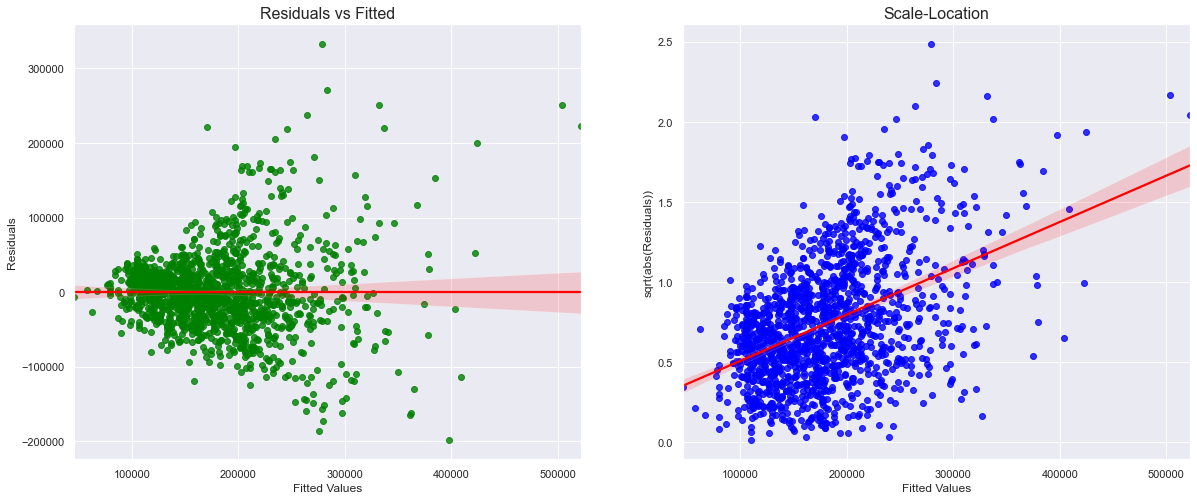

In [32]:
# Check the homoscedasticity of univariatve regression model with Saleprice and GrLivArea
## Check the plot first
 
y = df_train["SalePrice"]
x = df_train["GrLivArea"]
homoscedasticity_test_plot(x, y)

In [33]:
# Check with Breusch-Pagan and White Test
homoscedasticity_test(x, y)


 Breusch-Pagan test ----
                                      value
Lagrange multiplier statistic  2.491358e+02
p-value                        4.007319e-56
f-value                        3.001103e+02
f p-value                      2.843639e-61

 White-test test ----
                                      value
Lagrange multiplier statistic  2.949797e+02
p-value                        8.830307e-65
f-value                        1.845495e+02
f p-value                      3.760811e-72



 Breusch-Pagan test ----
                                      value
Lagrange multiplier statistic  6.156746e+01
p-value                        4.278305e-15
f-value                        6.419562e+01
f p-value                      2.290011e-15

 White-test test ----
                                      value
Lagrange multiplier statistic  7.851517e+01
p-value                        8.925805e-18
f-value                        4.140817e+01
f p-value                      3.237079e-18


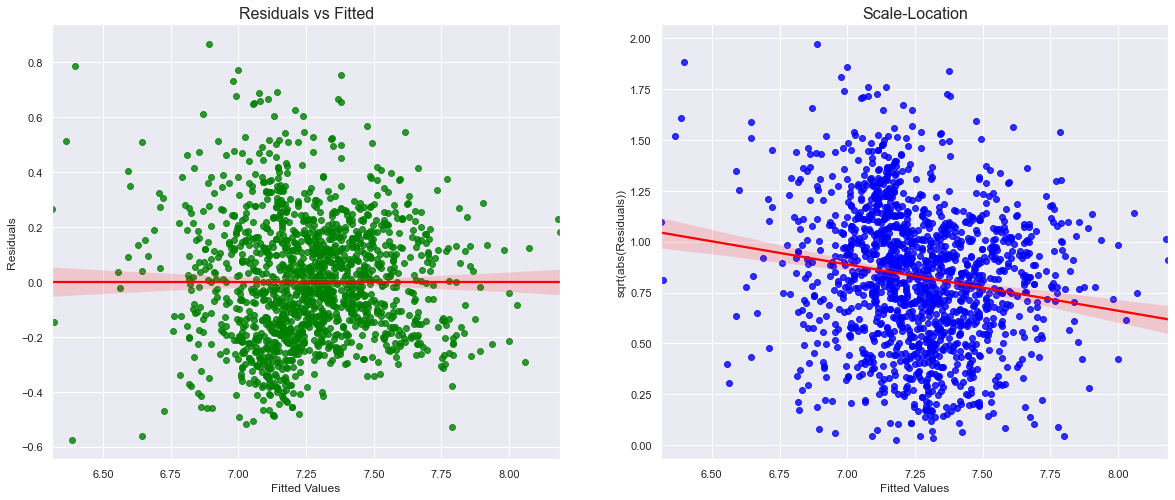

In [34]:
# I can find some con shape for the plot for the normarl model shape
## Let's use the log varaibles

x_1 = df_train["saleprice_log"]
y_1 = df_train["GrLivArea_log"]
homoscedasticity_test_plot(x_1, y_1)
homoscedasticity_test(x_1, y_1)

Still Pvalue is lower than 0.05, that we have to reject the null hyop that it is homoscedasticity, but plot with log variables seems better than the normal regression model


 Breusch-Pagan test ----
                                      value
Lagrange multiplier statistic  1.013861e+02
p-value                        7.569216e-24
f-value                        1.088192e+02
f p-value                      1.280550e-24

 White-test test ----
                                      value
Lagrange multiplier statistic  1.649114e+02
p-value                        1.548643e-36
f-value                        9.278819e+01
f p-value                      1.186894e-38


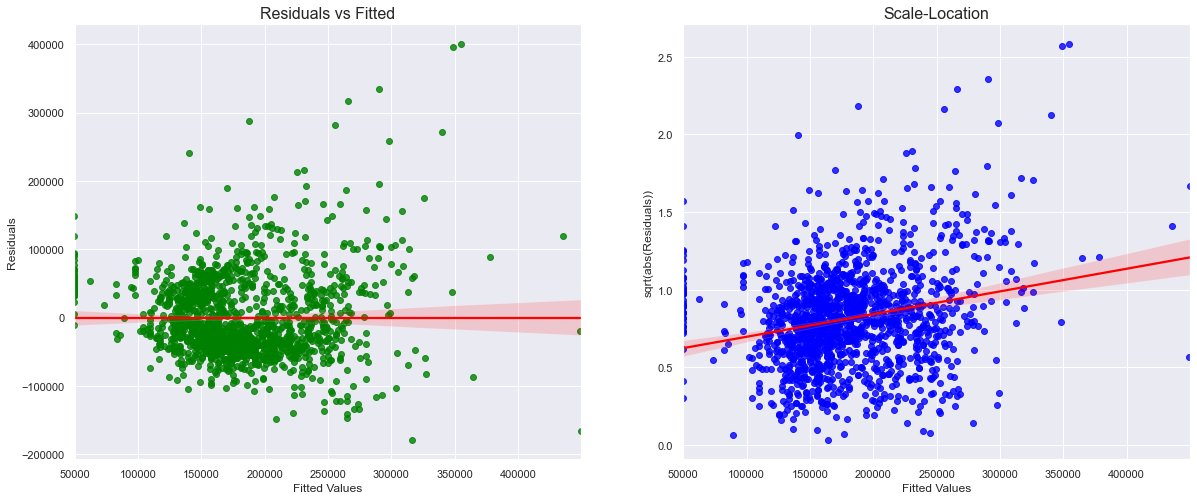

In [35]:
# Check the TotalBsmtSF

y = df_train["SalePrice"]
x = df_train["TotalBsmtSF"]
homoscedasticity_test_plot(x, y)
homoscedasticity_test(x, y)

## 6. Regression model
- It's time to build the regression model with the variables we choosed before
- Result Homoscedasticity test was not that good but when we add more variables, it may reduced the biased residuals
- Also I will do the error anaylsis to get the higher accuracy

In [263]:
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn import metrics


def print_evaluate(true, predicted):  
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('__________________________________')

def evaluate(true, predicted):  
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mse, rmse, r2_square

In [47]:
# Make the new dataframe which we choosed prior
new_cols = ['saleprice_log', 'OverallQual', 'GrLivArea_log', 'GarageCars', 'TotalBsmtSF_log',
       'FullBath', 'YearBuilt']
sel_df_train = df_train[new_cols]
sel_df_train

,saleprice_log,OverallQual,GrLivArea_log,GarageCars,TotalBsmtSF_log,FullBath,YearBuilt
0,12.247694,7,7.444249,2,6.752270,2,2003
1,12.109011,6,7.140453,2,7.140453,2,1976
2,12.317167,7,7.487734,2,6.824374,2,2001
3,11.849398,7,7.448334,3,6.628041,1,1915
4,12.429216,8,7.695303,3,7.043160,2,2000
...,...,...,...,...,...,...,...
1455,12.072541,6,7.406711,2,6.859615,2,1999
1456,12.254863,6,7.636752,2,7.340836,2,1978
1457,12.493130,7,7.757906,1,7.049255,2,1941
1458,11.864462,5,6.982863,1,6.982863,1,1950


In [56]:
# Since range of YearBuilt variable is high, let's take a log for it as well
sel_df_train["YearBuilt"] = np.log(sel_df_train["YearBuilt"])
sel_df_train

,saleprice_log,OverallQual,GrLivArea_log,GarageCars,TotalBsmtSF_log,FullBath,YearBuilt
0,12.247694,7,7.444249,2,6.752270,2,7.602401
1,12.109011,6,7.140453,2,7.140453,2,7.588830
2,12.317167,7,7.487734,2,6.824374,2,7.601402
3,11.849398,7,7.448334,3,6.628041,1,7.557473
4,12.429216,8,7.695303,3,7.043160,2,7.600902
...,...,...,...,...,...,...,...
1455,12.072541,6,7.406711,2,6.859615,2,7.600402
1456,12.254863,6,7.636752,2,7.340836,2,7.589842
1457,12.493130,7,7.757906,1,7.049255,2,7.570959
1458,11.864462,5,6.982863,1,6.982863,1,7.575585


In [57]:
# Split independend variables and dependent variable
y = sel_df_train["saleprice_log"]
X = sel_df_train[new_cols[1:]]

In [247]:
X_features = X.columns

In [289]:
X_features.values

array(['OverallQual', 'GrLivArea_log', 'GarageCars', 'TotalBsmtSF_log',
       'FullBath', 'YearBuilt'], dtype=object)

In [319]:
# Let's see the MSE, RMSE and R2 for different regression model the regression model with normal regression model
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

lgr = LinearRegression(normalize = False)
lgr.fit(X, y)
lgr_pred = lgr.predict(X)

print(f"------w, b, score of Linear model------ \nw: {lgr.coef_} \nb: {lgr.intercept_}")
print_evaluate(y, lgr_pred)

------w, b, score of Linear model------ 
w: [ 0.10174835  0.48818826  0.08300002  0.03586586 -0.02757208  5.39181103] 
b: -33.39257222385854
MSE: 0.027447151744674495
RMSE: 0.16567181940412948
R2 Square 0.828210937015325
__________________________________


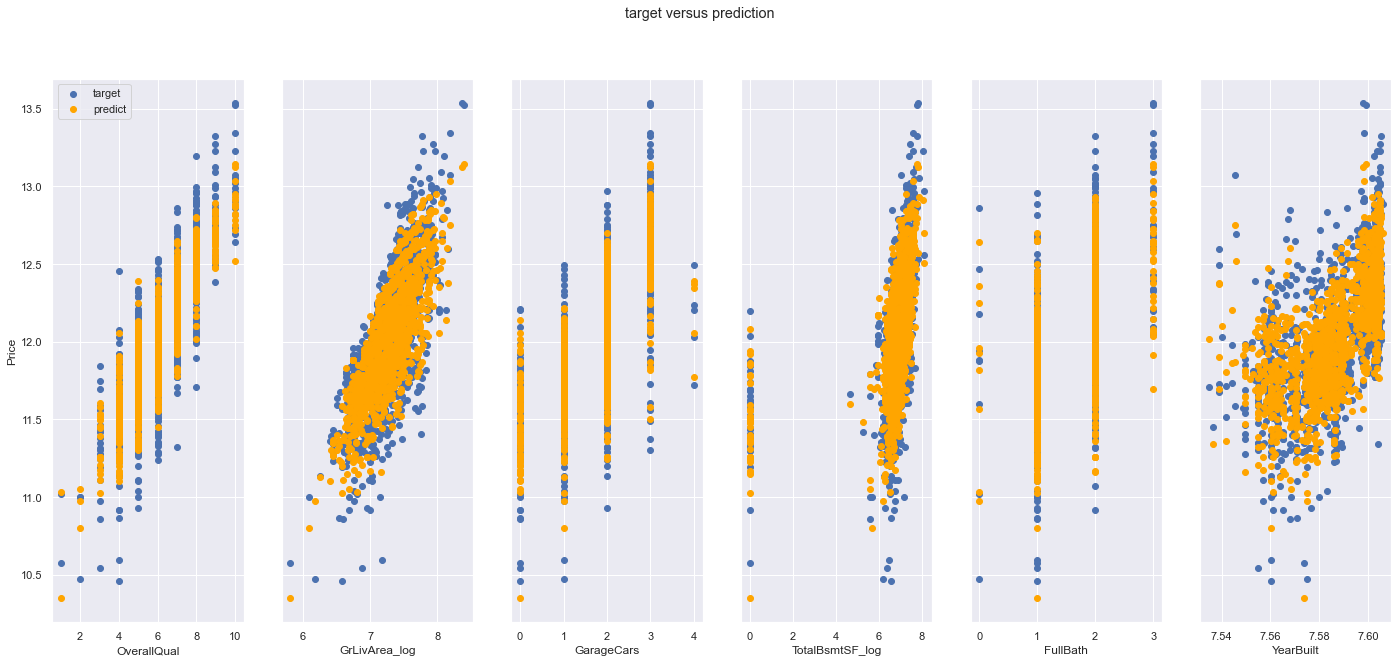

In [121]:
# plot predictions and targets vs original features    
fig,ax=plt.subplots(1,6,figsize=(24,10),sharey=True)

for i in range(len(ax)):
    ax[i].scatter(X.iloc[0:, i], y, label = 'target')
    ax[i].set_xlabel(X_features[i])
    ax[i].scatter(X.iloc[0:, i], lgr_pred, color = "orange", label = 'predict')
    
ax[0].set_ylabel("Price"); ax[0].legend();
fig.suptitle("target versus prediction")
plt.show()

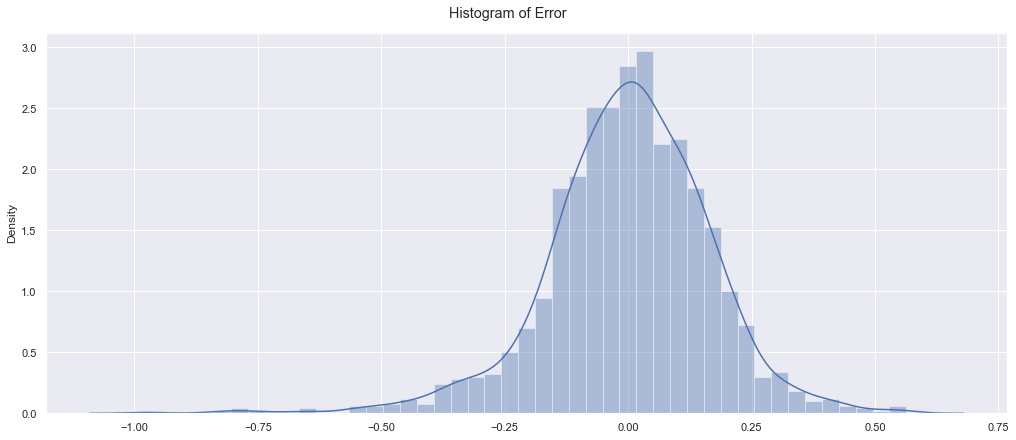

In [267]:
fig = plt.figure(constrained_layout = True, figsize = (14, 6))
sns.distplot(pd.DataFrame({'Error Values': (y - lgr_pred)}));
fig.suptitle("Histogram of Error");

In [320]:
# Find and Plot the coefficient of the varaibles

lgr_coef = pd.Series(lgr.coef_, index = X.columns)
lgr_coef

OverallQual        0.101748
GrLivArea_log      0.488188
GarageCars         0.083000
TotalBsmtSF_log    0.035866
FullBath          -0.027572
YearBuilt          5.391811
dtype: float64

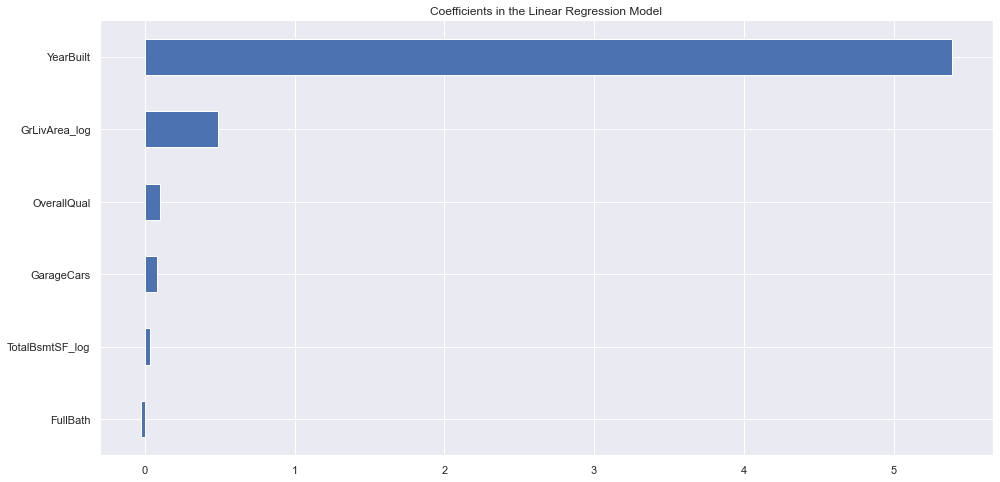

In [321]:
lgr_coef.sort_values().plot(kind = "barh", figsize = (16,8))
plt.title("Coefficients in the Linear Regression Model");